# LightGBM

In [43]:
#Setting up environment
#Purpose: import all libraries used in this notebook (data handling, preprocessing, modelling, evaluation).
!pip -q install shap
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
from time import perf_counter
import joblib
import warnings

from lightgbm import LGBMClassifier
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("Environment ready. SHAP available:", SHAP_AVAILABLE)

Environment ready. SHAP available: True


### Load the dataset and define the modelling target.
We build X (features) by dropping the target and any identifier columns (like ID) to avoid leakage.
The target y is coerced into a clean binary 0/1 integer label.
Explicitly handles missing values and class balance


In [44]:
# 2 load data
df = pd.read_csv("wallacecommunications.csv")
TARGET = "new_contract_this_campaign"

X = df.drop(columns=[TARGET, "ID"], errors="ignore")
y = df[TARGET]

# make sure y is 0/1
if y.dtype == "object":
    y = y.astype(str).str.lower().map({"yes":1, "no":0, "true":1, "false":0, "y":1, "n":0})
y = y.astype(int)

### Split strategy

Holds out a final test set (20%) and keep a validation set (20%) for model selection.
stratify=y preserves the class imbalance ratio across splits, which is important for ROC-AUC.


In [45]:
#3 Train/Val/Test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE , stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE, stratify=y_trainval
)

### Preprocessing with sklearn Pipelines/ColumnTransformer:
- Numeric: median imputation handles missing values robustly.
- Categorical: most-frequent imputation + one-hot encoding converts strings to numeric indicators.
- min_frequency groups rare categories to reduce dimensionality and help generalisation.
- Using a Pipeline prevents data leakage because transformations are learned only on training folds.


In [46]:
#4 Preprocess
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=20)),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

# LightGBM Model
 
Define the LightGBM model inside a Pipeline so preprocessing is applied consistently in CV and at inference.

class_weight='balanced' compensates for class imbalance by up-weighting the minority class.

The param_dist below defines the hyperparameter search space for RandomizedSearchCV.


In [47]:
# 5 LightGBM and Hyperparameter tuning

lgbm = LGBMClassifier(
    objective="binary",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced",
    verbosity = -1,
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", lgbm),
])

param_dist = {
    "model__n_estimators": [300, 600, 1000],
    "model__learning_rate": [0.02, 0.05, 0.1],
    "model__num_leaves": [15, 31, 63, 127],
    "model__max_depth": [-1, 5, 10, 15],
    "model__min_child_samples": [10, 20, 50, 100],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_alpha": [0.0, 0.1, 1.0],
    "model__reg_lambda": [0.0, 0.1, 1.0],
}

# Cross-validation set up

StratifiedKFold keeps class proportions in each fold.
RandomizedSearchCV samples n_iter parameter combinations and evaluates using ROC-AUC.


In [48]:
#6 CV 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=1,
    verbose=1,
    error_score="raise"
)

# Fitting hyperparameter search  & persist outputs
- We time the run for reporting.
- cv_results_ is exported for later analysis / write-up.
- The best pipeline is saved with joblib so the exact preprocessing+model can be reused.


In [49]:
warnings.filterwarnings("ignore", message="X does not have valid feature names*")

t0 = perf_counter()
search.fit(X_train, y_train)
best_lgbm = search.best_estimator_
pd.DataFrame(search.cv_results_).to_csv("LightGMB_cv_results.csv", index=False)
joblib.dump(search.best_estimator_, "best_LightGBM_pipeline.joblib")
t1 = perf_counter()

print(f"Seconds for 5*15 = 75 fits:", t1 - t0)
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Seconds for 5*15 = 75 fits: 128.6710087999818
Best params: {'model__subsample': 1.0, 'model__reg_lambda': 0.1, 'model__reg_alpha': 1.0, 'model__num_leaves': 127, 'model__n_estimators': 600, 'model__min_child_samples': 50, 'model__max_depth': -1, 'model__learning_rate': 0.02, 'model__colsample_bytree': 0.6}
Best CV ROC-AUC: 0.8471123344475933


## Validation evaluation

We first compute ROC-AUC using predicted probabilities (threshold-free metric).
Then we convert probabilities into class labels using:
- a default decision threshold of 0.50 (common baseline), and
- an F1-optimised threshold chosen from the validation precision–recall curve.

### IMPORTANT
classification report / confusion matrix depend on the chosen threshold,
so we report them for both 0.50 and the best-F1 threshold to show the trade-off.
The F1-optimised threshold is selected ONLY on the validation set and then reused for test.


In [50]:
# 7 Validation
val_proba = best_lgbm.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)
print("\nValidation ROC-AUC:", roc_auc_score(y_val, val_proba))

# probabilities on validation set
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]

# OPTION 1: use default threshold 0.5
y_val_pred_05 = (y_val_proba >= 0.5).astype(int)
print("Classification report @ threshold=0.50")
print(classification_report(y_val, y_val_pred_05, digits=3))

# OPTION 2: choose threshold that maximizes F1 on validation
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)

best_idx = np.argmax(f1)
best_threshold = thr[best_idx]  # thresholds array is length-1 compared to prec/rec
print(f"Best F1 threshold on validation: {best_threshold:.3f}")

y_val_pred_best = (y_val_proba >= best_threshold).astype(int)
print(f"Classification report @ threshold={best_threshold:.3f}")
print(classification_report(y_val, y_val_pred_best, digits=3))


Validation ROC-AUC: 0.8550048504175819
Classification report @ threshold=0.50
              precision    recall  f1-score   support

           0      0.919     0.876     0.897      8153
           1      0.571     0.683     0.622      1980

    accuracy                          0.838     10133
   macro avg      0.745     0.779     0.759     10133
weighted avg      0.851     0.838     0.843     10133

Best F1 threshold on validation: 0.517
Classification report @ threshold=0.517
              precision    recall  f1-score   support

           0      0.917     0.885     0.901      8153
           1      0.586     0.670     0.625      1980

    accuracy                          0.843     10133
   macro avg      0.752     0.778     0.763     10133
weighted avg      0.852     0.843     0.847     10133


# Final evaluation

Refit best model on train+validation, then evaluate once on the untouched test set.

Compute ROC-AUC using probabilities, and then report classification metrics at:
- threshold=0.50 (baseline)
- the validation-selected best_threshold (operating point chosen without looking at test)

In [51]:
#8 Test
best_lgbm.fit(X_trainval, y_trainval)

test_proba = best_lgbm.predict_proba(X_test)[:, 1]
print("\nTEST ROC-AUC:", roc_auc_score(y_test, test_proba))

# Baseline @ 0.50
test_pred_05 = (test_proba >= 0.5).astype(int)
print("\nConfusion matrix (threshold=0.50):")
print(confusion_matrix(y_test, test_pred_05))
print("\nClassification report (threshold=0.50):")
print(classification_report(y_test, test_pred_05, digits=3))


TEST ROC-AUC: 0.8741979465946105

Confusion matrix (threshold=0.50):
[[7116 1037]
 [ 584 1396]]

Classification report (threshold=0.50):
              precision    recall  f1-score   support

           0      0.924     0.873     0.898      8153
           1      0.574     0.705     0.633      1980

    accuracy                          0.840     10133
   macro avg      0.749     0.789     0.765     10133
weighted avg      0.856     0.840     0.846     10133


In [55]:
# Validation-chosen threshold
test_pred_best = (test_proba >= best_threshold).astype(int)
print("\nTEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print(f"\nConfusion matrix (threshold={best_threshold:.3f}):")
print(confusion_matrix(y_test, test_pred_best))
print(f"\nClassification report (threshold={best_threshold:.3f}):")
print(classification_report(y_test, test_pred_best, digits=3))
print("Best params:")
print(search.best_params_)


TEST ROC-AUC: 0.8741979465946105

Confusion matrix (threshold=0.517):
[[7200  953]
 [ 623 1357]]

Classification report (threshold=0.517):
              precision    recall  f1-score   support

           0      0.920     0.883     0.901      8153
           1      0.587     0.685     0.633      1980

    accuracy                          0.844     10133
   macro avg      0.754     0.784     0.767     10133
weighted avg      0.855     0.844     0.849     10133

Best params:
{'model__subsample': 1.0, 'model__reg_lambda': 0.1, 'model__reg_alpha': 1.0, 'model__num_leaves': 127, 'model__n_estimators': 600, 'model__min_child_samples': 50, 'model__max_depth': -1, 'model__learning_rate': 0.02, 'model__colsample_bytree': 0.6}


# Confusion matrix visualisation 

Set at the 0.517 threshold.

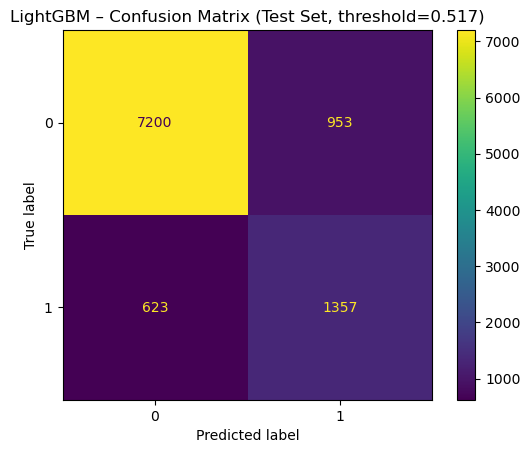

In [53]:
cm = confusion_matrix(y_test, test_pred_best)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format="d")
plt.title(f"LightGBM – Confusion Matrix (Test Set, threshold={best_threshold:.3f})")
plt.show()